In [72]:
import os
import json
import shutil
from ghost.misc import ghost_path
from ghost.bids import bids2stats, plot_mimics, plot_signal_ROI
import bids
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

In [42]:
def download_zip(url, dir, zip_file_name):
    urllib.request.urlretrieve(url, os.path.join(dir, zip_file_name))
    print(f"Downloaded {zip_file_name}")

    with zipfile.ZipFile(os.path.join(dir, zip_file_name), 'r') as zip_ref:
        zip_ref.extractall(dir)
    os.remove(os.path.join(dir, zip_file_name))
    
    print("Extracting data")
    if os.path.exists(os.path.join(dir, '__MACOSX')):
        shutil.rmtree(os.path.join(dir, '__MACOSX'))
        print("Removed __MACOSX folder")

# Demo notebook
This short demo will go through some basic usage of the `ghost` python module. The key features of `ghost` is to segment and process data from the UNITY phantom. There are two ways of doing this

1. Commandline interface: Recommended for just a few images or for development
2. BIDS structure. This is when you have a larger QA study you want to investigate. 

Both approaches will be demonstrated in this notebook.

## 1. Command line interface demo

In [38]:
# Grab some example data
demo_cli_dir=f'{ghost_path()}/demo/cli'
os.makedirs(demo_cli_dir, exist_ok=True)
download_zip('https://www.dropbox.com/s/qmvbfzu113e1yyw/Swoop_T2_nifti.zip?dl=1', demo_cli_dir, 'Swoop_T2_nifti.zip')

demo_cli_dir += '/Swoop_T2_nifti'
print(f"We have the following demo files in {demo_cli_dir}:")
os.listdir(demo_cli_dir)

We have the following demo files in /Users/emil/Code/GHOST/ghost/../demo/cli/Swoop_T2_nifti:


['.DS_Store', 'T2w_sag.nii.gz', 'T2w_cor.nii.gz', 'T2w_axi.nii.gz']

The command we are interested in here is `ghost warp_rois`, let's see how we use it

In [33]:
!ghost warp_rois -h

usage: ghost warp_rois <input> [<args>]]

Warp ROIs to target image

positional arguments:
  input                 Input image

options:
  -h, --help            show this help message and exit
  -w WEIGHTING, --weighting WEIGHTING
                        Phantom weighting (T1 or T2)
  -s SEG, --seg SEG     Segmentation (T1, T2, ADC)
  -o OUT, --out OUT     Output basename (default is input basename)
  --vol VOL             Volume to use (default is last volume)


In [40]:
f = demo_cli_dir + '/T2w_axi.nii.gz'
!ghost warp_rois {f} -w T2 -s T1 -s T2 -s ADC

Saved /Users/emil/Code/GHOST/ghost/../demo/cli/Swoop_T2_nifti/T2w_axi_maskT1.nii.gz
Saved /Users/emil/Code/GHOST/ghost/../demo/cli/Swoop_T2_nifti/T2w_axi_maskT2.nii.gz
Saved /Users/emil/Code/GHOST/ghost/../demo/cli/Swoop_T2_nifti/T2w_axi_maskADC.nii.gz


Now we have three segmentations that we can use for our analysis. Let's look at this with matplotlib.

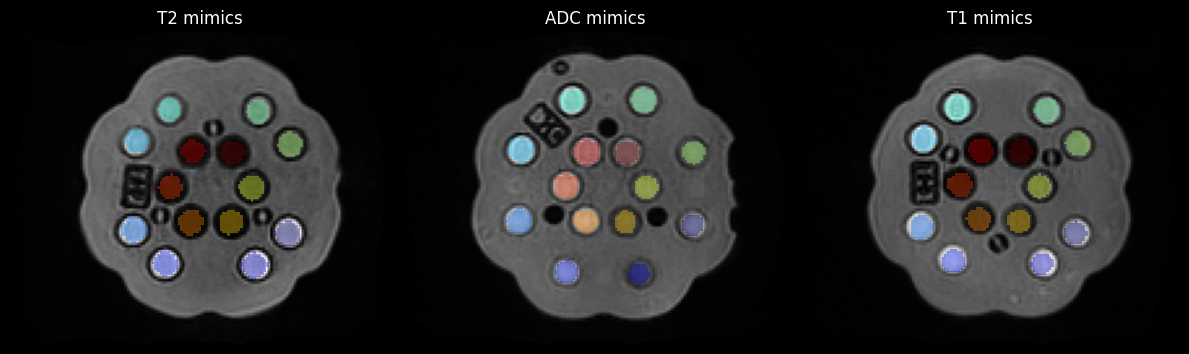

In [87]:
fbase = demo_cli_dir + '/T2w_axi'
img = nib.load(fbase+'.nii.gz').get_fdata()
masks = ['T1', 'T2', 'ADC']
T1mask = nib.load(fbase+'_maskT1.nii.gz').get_fdata()
T2mask = nib.load(fbase+'_maskT2.nii.gz').get_fdata()
ADCmask = nib.load(fbase+'_maskADC.nii.gz').get_fdata()

# This is to make the plotting look nicer
T1mask[T1mask == 0 ] = np.nan
T2mask[T2mask == 0 ] = np.nan
ADCmask[ADCmask == 0 ] = np.nan

# Plot the base images
plt.style.use('dark_background')
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].imshow(img[:,:,14], cmap='gray'); axs[0].set_title('T2 mimics'); axs[0].axis('off')
axs[0].imshow(T2mask[:,:,14], cmap='jet', alpha=0.35)

axs[1].imshow(img[:,:,18], cmap='gray'); axs[1].set_title('ADC mimics'); axs[1].axis('off')
axs[1].imshow(ADCmask[:,:,18], cmap='jet', alpha=0.35)

axs[2].imshow(img[:,:,25], cmap='gray'); axs[2].set_title('T1 mimics'); axs[2].axis('off')
axs[2].imshow(T1mask[:,:,25], cmap='jet', alpha=0.35)

plt.tight_layout()

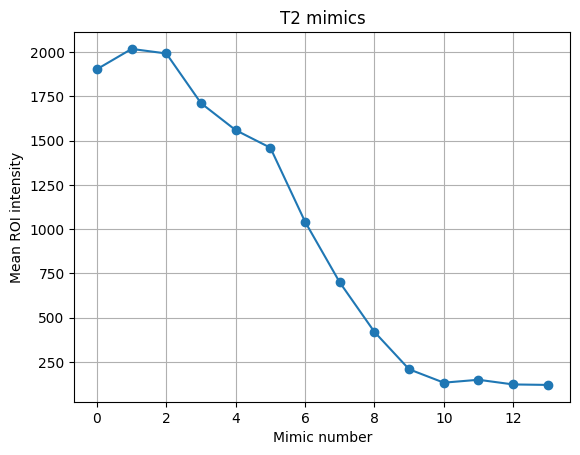

In [89]:
# Extract ROI values in a simple way
T2_roi_vals = []
n_mimics = int(np.max(T2mask[T2mask>0]))
for i in range(1, n_mimics+1): # ROIs start with 1
    T2_roi_vals.append(np.mean(img[T2mask == i]))

plt.style.use('default')
plt.figure()
plt.plot(T2_roi_vals, 'o-')
plt.xlabel('Mimic number')
plt.ylabel('Mean ROI intensity')
plt.title('T2 mimics')
plt.grid()
plt.show()

## 2. BIDS Demo
### Setup directories
We set up the demo project inside the GHOST directory as a BIDS structure to keep it neat and tidy

In [106]:
demo_dir=f'{ghost_path()}/demo/bids'
os.makedirs(demo_dir, exist_ok=True)
os.environ['PROJECT_DIR'] = demo_dir    # Used later in the BIDS analysis

# Create BIDS directory structure
folders=['code', 'sourcedata', 'rawdata', 'derivatives']
for folder in folders:
    os.makedirs(os.path.join(demo_dir,folder), exist_ok=True)

# put needful code in place (turns messy DICOM directory into sparkling BIDS structure)
shutil.copytree(f'{ghost_path()}/dcm2bids', os.path.join(demo_dir,'code/dcm2bids'), dirs_exist_ok=True)

download_zip('https://www.dropbox.com/s/p0uzg47wppknpyg/LUND_DailyQA_demo.zip?dl=1', 
             f'{demo_dir}/sourcedata', 'Lund_DailyQA_Example.zip')

Downloaded Lund_DailyQA_Example.zip
Extracting data
Removed __MACOSX folder


Now we have defined one non-BIDS dataset (`sourcedata`), and two BIDS datasets: `Rawdata` and `Derivatives`. As for any BIDS dataset, a `dataset_description.json` file must be found at the top level. Therefore, we must create these two before we can BIDS-ify our source data.

In [107]:
# Create the dataset_description.json file for the rawdata folder
with open(os.path.join(demo_dir,'rawdata/dataset_description.json'), 'w') as f:
    # Here is what the file should resemble
    json.dump(
        {
            "Name": "demo",
            "BIDSVersion": "1.8",
            "DatasetType": "raw",
            "License": "",
            "Authors": [
                "Petter Clemensson",
                "Emil Ljungberg",
                ],
            "Funding": "The Bill & Melinda Gates Foundation",
        }
        , f, indent=4)

Only `Name` and `BIDSVersion` are required fields, while the others are recommended/optional. More info available on the [BIDS website](https://bids-specification.readthedocs.io/en/stable/03-modality-agnostic-files.html#dataset_descriptionjson).

In [108]:
# Create the dataset_description.json file for the derivatives folder
with open(os.path.join(demo_dir,'derivatives/dataset_description.json'), 'w') as f:
    # Here is what the file should resemble
    json.dump(
        {
            "Name": "demo",
            "BIDSVersion": "1.8",
            "DatasetType": "derivative",
            "License": "",
            "Authors": [
                "Petter Clemensson",
                "Emil Ljungberg",
                ],
            "Funding": "The Bill & Melinda Gates Foundation",
            "GeneratedBy": [
                {
                    "Name": "masks",
                    "Description": "Segmentations for all the images in the dataset"
                },
                {
                    "Name": "qa",
                    "Description": "Quality assurance for all the image in the dataset"
                },
                {
                    "Name": "stats",
                    "Description": "Statistics for all the image in the dataset",
                },
            ],
            
        }
        , f, indent=4)

Before we intiate the BIDS-ification, we may want to define some additional DICOM tags (metadata) that we want to add to the JSON sidecar, as not everything is included when using `dcm2bids`. For this purpose, we use a function available through the swoop_QMRI package, `swoop_update_sidecar`. It requires a `dicom_update_tags.csv` file, which we can add to our `code/` directory by running the following cell.

In [109]:
with open(os.path.join(demo_dir,'code/dicom_update_tags.csv'), 'w') as f:
    # Here is what the file should resemble
    lines = ['DicomTag, dtype, regex, name\n',
             '0x03511000, float, None, tmp_min\n',
             '0x03511001, float, None, tmp_max\n',
             '0x03511002, float, None, uint_x_max\n',
             '0x00104000, int, \d{2}, Temperature\n',
             '0x52009229/0x00189006/0x00189098, float, None, CenterFrequency']
    f.writelines(lines)

### Sourcedata &rarr; Rawdata (BIDS!)
Usually this is done by excecuting `bash run_dcm2bids.sh`. When working on your own project, set `PROJECT_DIR` to your project directory before the execution.

The next cell mirrors `run_dcm2bids.sh` so there is no need to leave this demo to edit the file. The only difference is that `PROJECT_DIR` is automatically assigned the demo project directory.

In [110]:
%%bash

PARTICIPANT_ID="LUND"

DICOM_DIR="$PROJECT_DIR/sourcedata/*"
CONFIG_FILE="$PROJECT_DIR/code/dcm2bids/config.json"
OUTPUT_DIR="$PROJECT_DIR/rawdata"

i=1
for DIR in $DICOM_DIR
do
    # extract the session ID from the dicom directory name
    if [[ $DIR =~ [0-9]{8} ]]; then
        SESSION_ID=$(echo $DIR | grep -oE "[0-9]{8}")
    # session ID is set to the session number if the directory name does not contain a date
    else
        SESSION_ID=$i
        i=$((i+1))
    fi

  # run the function on the directory and session ID
  dcm2bids -d $DIR -p $PARTICIPANT_ID -s $SESSION_ID -c $CONFIG_FILE -o $OUTPUT_DIR
  
  # Transfer metadata from DICOM tags in dicom_update_tags.csv to sidecar files
  ghost update_sidecar $DIR $OUTPUT_DIR/sub-$PARTICIPANT_ID/ses-$SESSION_ID -m $PROJECT_DIR/code/dicom_update_tags.csv
done

INFO:dcm2bids.dcm2bids:--- dcm2bids start ---
INFO:dcm2bids.dcm2bids:OS:version: macOS-13.1-arm64-arm-64bit
INFO:dcm2bids.dcm2bids:python:version: 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]
INFO:dcm2bids.dcm2bids:dcm2bids:version: 2.1.7
INFO:dcm2bids.dcm2bids:dcm2niix:version: v1.0.20220720
INFO:dcm2bids.dcm2bids:participant: sub-LUND
INFO:dcm2bids.dcm2bids:session: ses-1
INFO:dcm2bids.dcm2bids:config: /Users/emil/Code/GHOST/demo/bids/code/dcm2bids/config.json
INFO:dcm2bids.dcm2bids:BIDS directory: /Users/emil/Code/GHOST/demo/bids/rawdata
INFO:dcm2bids.utils:Running ['dcm2niix', '-b', 'y', '-ba', 'y', '-z', 'y', '-f', '%3s_%f_%p_%t', '-x', 'i', '-o', PosixPath('/Users/emil/Code/GHOST/ghost/../demo/bids/rawdata/tmp_dcm2bids/sub-LUND_ses-1'), PosixPath('/Users/emil/Code/GHOST/ghost/../demo/bids/sourcedata/LUND_DailyQA_demo')]
INFO:dcm2bids.dcm2niix:Check log file for dcm2niix output
INFO:dcm2bids.sidecar:Sidecars pairing:
INFO:dcm2bids.sidecar:No Pairing  <-  003_LUND_DailyQA_d

### Final comment on the BIDS-ification
Now the `rawdata/` folder contains a BIDS compatible directory (`sub-LUND/`) and a temporary folder (`tmp_dcm2bids`). In the temporary folder we find files that were converted to NIFTI, but couldn't be BIDSified. This can happen for a few reasons. 
1. No match was find with the description criteria in the `config.json` file. (Here, we're not interested in the localizer image so we couldn't be bothered to include an identifier for it). If you want to practice, go and edit the `config.json` file and re-run the previous cell until the localizer image is successfully BIDSified.
2. Multiple matches were found for a single description criterion. If this is the case, you can inspect the sidecar file and look for the "SeriesDescription" field for example. It is often a good unique identifier.

For a more comprehensive tutorial, check [this](https://unfmontreal.github.io/Dcm2Bids/docs/tutorial/first-steps/) out.

### Swift analysis
Here follows some basic analysis examples that aim to get you started. Manipulate as you wish to suit your own needs.

In [111]:
# Get project layout and update 
layout = bids.BIDSLayout(root=demo_dir+'/rawdata', derivatives=demo_dir+'/derivatives')

# Select all fast axial T2 images
bids_files = layout.get(scope='raw', extension='.nii.gz', suffix='T2w', reconstruction='axi', acquisition='fast')

# Get the stats for the T2 images and save to Excel
stats_T2 = bids2stats(bids_files, 'T2', layout, toExcel=True, verbose=True)
print(f"Stats for some T2 data: \n {stats_T2}")

A T2-mask does not exist for sub-LUND_ses-1_acq-fast_rec-axi_run-01_T2w.nii.gz. Molding one now.
Saving T2 mask to /Users/emil/Code/GHOST/ghost/../demo/bids/derivatives/masks/sub-LUND/ses-1/anat/sub-LUND_ses-1_acq-fast_rec-axi_run-01_desc-T2_T2w.nii.gz...
A T2-mask does not exist for sub-LUND_ses-1_acq-fast_rec-axi_run-02_T2w.nii.gz. Molding one now.
Saving T2 mask to /Users/emil/Code/GHOST/ghost/../demo/bids/derivatives/masks/sub-LUND/ses-1/anat/sub-LUND_ses-1_acq-fast_rec-axi_run-02_desc-T2_T2w.nii.gz...
A T2-mask does not exist for sub-LUND_ses-1_acq-fast_rec-axi_run-03_T2w.nii.gz. Molding one now.
Saving T2 mask to /Users/emil/Code/GHOST/ghost/../demo/bids/derivatives/masks/sub-LUND/ses-1/anat/sub-LUND_ses-1_acq-fast_rec-axi_run-03_desc-T2_T2w.nii.gz...
Stats for some T2 data: 
     LabelValue         Mean    Min     Max       Variance  Count       Volume  \
0          1.0  1916.542735  362.0  2594.0  254862.609754  234.0  2995.200195   
14         1.0  2008.697674  213.0  2782.0  

In [104]:
# Update layout
layout = bids.BIDSLayout(root=demo_dir+'/rawdata', derivatives=demo_dir+'/derivatives')

# Retreive all the b0 DWI images
bids_files = layout.get(scope='raw', extension='.nii.gz', suffix='dwi', acquisition='b0', session='20230329')

# Plot the QA images of the bids files
plot_mimics(bids_files, layout, toFile=True, verbose=True)

A T1-mask already exists for sub-LUND_ses-1_acq-std_rec-cor_run-01_T1w.nii.gz.
A T1-mask already exists for sub-LUND_ses-1_acq-std_rec-cor_run-02_T1w.nii.gz.
A T1-mask already exists for sub-LUND_ses-1_acq-std_rec-cor_run-03_T1w.nii.gz.


ValueError: time data '1' does not match format '%Y%m%d'

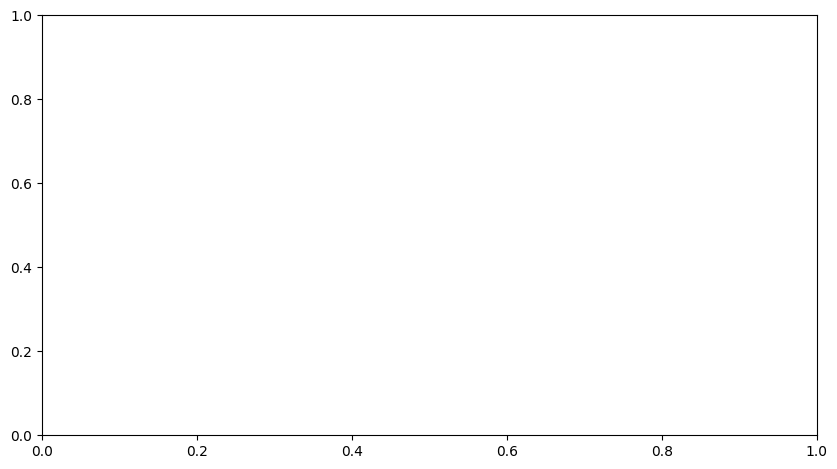

In [102]:
# Plot Mean of each LabelValue as a function of Session (time). Each LabelValue corresponds to it's own line.
# Update layout
layout = bids.BIDSLayout(root=demo_dir+'/rawdata', derivatives=demo_dir+'/derivatives')

# Select all standard coronal T1w images
bids_files = layout.get(scope='raw', extension='.nii.gz', suffix='T1w', acquisition='std', reconstruction='cor')

plot_signal_ROI(bids_files, 'T1', layout, verbose=True)